# Optimizing Neural Networks for CIFAR-10 Image Classiﬁcation

## Importing Libraries

In [1]:
from tensorflow import keras
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

## Mounting Google Drive

Since the project is done mostly in Google Colab, it will be helpful to connect Google Drive to be able to save and load files from there.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the dataset

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Let's look at the shape of training and test sets of loaded dataset.

In [3]:
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


## Data preprocesing

Let's explore our dataset little bit.

### Checking missing values

Let's make sure that we don't have any missing values.

In [7]:
nan_count = np.isnan(X_train).sum()
print("Number of missing values in X_train:", nan_count)

Number of missing values in X_train: 0


### Scaling the data

Our DNN will require scaling. Let's divide all intensity values by 255 to scale it to range [0,1].

In [6]:
X_train_scaled = X_train.astype('float32') / 255.0
X_test_scaled = X_test.astype('float32') / 255.0

### Visualizing some images

Finally, let's visualize the images and the corresponding labels to get a better understanding of how they look like.

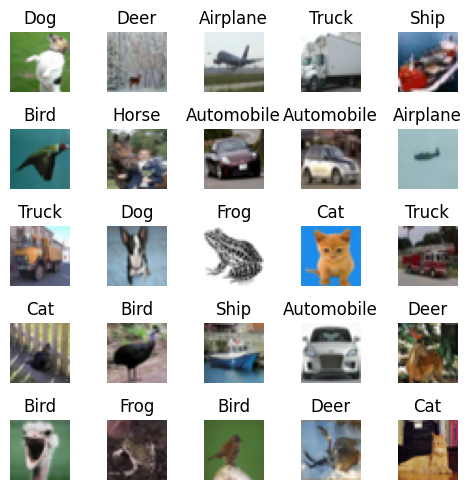

In [15]:
# CIFAR-10 class labels
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Select 25 random images
num_images = 25
indices = np.random.choice(X_train.shape[0], num_images, replace=False)
selected_images = X_train[indices]
selected_labels = y_train[indices]

# Plot the images in a 5x5 grid
plt.figure(figsize=(5, 5))
for i in range(num_images):
    plt.subplot(5, 5, i + 1)
    plt.imshow(selected_images[i])
    plt.title(class_names[selected_labels[i][0]])  # Convert label to class name
    plt.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

## Building Neural Network models

Now, after the preprocessing step is done, we can start building Neural Network models.

### Deep Neural Network (DNN)

We will start with the DNN. We will use 20 hidden layers, each containing 100 neurons. We are going to use He initialization and Swish activation function. For the optimization we will apply Nadam optimizer with early stopping.

In [28]:
dnn = keras.models.Sequential()

dnn.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    dnn.add(keras.layers.Dense(
            units=100,
            activation='swish',
            kernel_initializer='he_normal'
        ))

dnn.add(keras.layers.Dense(10, activation='softmax'))

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

In [8]:
dnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 100)                 │         307,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 500,210 (1.91 MB)

 Trainable params: 500,210 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]

best_val_accuracy = 0
best_lr = None

for lr in learning_rates:
  print(f"Training with learning rate: {lr}")
  dnn = keras.models.Sequential()

  dnn.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
  for _ in range(20):
      dnn.add(keras.layers.Dense(
              units=100,
              activation='swish',
              kernel_initializer='he_normal'
          ))

  dnn.add(keras.layers.Dense(10, activation='softmax'))

  dnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Nadam(learning_rate=lr),
    metrics=['accuracy']
    )

  early_stopping = keras.callbacks.EarlyStopping(
      monitor='val_accuracy',
      patience=10,
      restore_best_weights=True
  )

  checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/My Drive/best_dnn.keras',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max'
    )

  history_dnn = dnn.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    callbacks=[early_stopping]
  )

  val_acc = max(history_dnn.history['val_accuracy'])
  print(f"Final Validation Accuracy: {val_acc:.4f}")


  if val_acc > best_val_accuracy:
    best_val_accuracy = val_acc
    best_lr = lr

print(f"\nBest Learning Rate: {best_lr}, Best Validation Accuracy: {best_val_accuracy:.4f}")

Training with learning rate: 0.1
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.0976 - loss: 16170907.0000 - val_accuracy: 0.1022 - val_loss: 2.3161
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.0995 - loss: 2.3128 - val_accuracy: 0.1016 - val_loss: 2.3107
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.1011 - loss: 2.3132 - val_accuracy: 0.0977 - val_loss: 2.3193
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.1011 - loss: 2.3149 - val_accuracy: 0.1014 - val_loss: 2.3084
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.1008 - loss: 2.3134 - val_accuracy: 0.1022 - val_loss: 2.3114
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.0999 - loss: 2.3146 - val_accuracy: 0.1014 - val_loss: 2.3087
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.1027 - loss: 2.3140 - val_accuracy: 0.1016 - val_loss: 2.3093
Epoch 8/100
1250/1250 ━━━━━━━

Now, let's apply batch normalization

In [8]:
dnn = keras.models.Sequential()

dnn.add(keras.layers.Flatten(input_shape=[32, 32, 3]))

dnn.add(keras.layers.BatchNormalization())

for _ in range(20):
    dnn.add(keras.layers.Dense(units=100, kernel_initializer='he_normal', activation=None))
    dnn.add(keras.layers.BatchNormalization())
    dnn.add(keras.layers.Activation('swish'))

dnn.add(keras.layers.Dense(10, activation='softmax'))

dnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Nadam(learning_rate=0.0001),
    metrics=['accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

history_dnn = dnn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 23ms/step - accuracy: 0.1270 - loss: 2.4188 - val_accuracy: 0.1940 - val_loss: 2.4976
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step - accuracy: 0.2145 - loss: 2.1303 - val_accuracy: 0.2720 - val_loss: 2.0913
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.2838 - loss: 1.9534 - val_accuracy: 0.3353 - val_loss: 1.8969
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - accuracy: 0.3277 - loss: 1.8525 - val_accuracy: 0.3745 - val_loss: 1.7772
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.3606 - loss: 1.7687 - val_accuracy: 0.4007 - val_loss: 1.6881
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.3888 - loss: 1.6991 - val_accuracy: 0.4172 - val_loss: 1.6321
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.4104 - loss: 1.6525 - val_accuracy: 0.4304 - val_loss: 1.5983
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 

In [9]:
dnn.save('/content/drive/My Drive/dnn_batch_normalization.keras')

In [10]:
dnn = keras.models.Sequential()

dnn.add(keras.layers.Flatten(input_shape=[32, 32, 3]))

dnn.add(keras.layers.BatchNormalization())

for _ in range(20):
    dnn.add(keras.layers.Dense(units=100, kernel_initializer='he_normal', activation=None))
    dnn.add(keras.layers.BatchNormalization())
    dnn.add(keras.layers.Activation('swish'))
    dnn.add(keras.layers.Dropout(rate=0.2))

dnn.add(keras.layers.Dense(10, activation='softmax'))

dnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Nadam(learning_rate=0.0001),
    metrics=['accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

history_dnn = dnn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 25ms/step - accuracy: 0.1035 - loss: 2.5362 - val_accuracy: 0.0996 - val_loss: 2.3100
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.1030 - loss: 2.4143 - val_accuracy: 0.0998 - val_loss: 2.3128
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.1068 - loss: 2.3674 - val_accuracy: 0.0999 - val_loss: 2.3164
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.1161 - loss: 2.3222 - val_accuracy: 0.1006 - val_loss: 2.3331
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.1279 - loss: 2.2819 - val_accuracy: 0.1033 - val_loss: 2.3451
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.1475 - loss: 2.2356 - val_accuracy: 0.0998 - val_loss: 2.3728
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - accuracy: 0.1550 - loss: 2.1994 - val_accuracy: 0.1006 - val_loss: 2.3739
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 

In [9]:
dnn = keras.models.Sequential()

dnn.add(keras.layers.Input(shape=[32, 32, 3]))
dnn.add(keras.layers.Flatten())

dnn.add(keras.layers.BatchNormalization())

for _ in range(20):
    dnn.add(keras.layers.Dense(units=100, kernel_initializer='lecun_normal', activation=None))
    dnn.add(keras.layers.BatchNormalization())
    dnn.add(keras.layers.Activation('selu'))
    dnn.add(keras.layers.AlphaDropout(rate=0.2))

dnn.add(keras.layers.Dense(10, activation='softmax'))

dnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Nadam(learning_rate=0.0001),
    metrics=['accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

history_dnn = dnn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 55s 28ms/step - accuracy: 0.1023 - loss: 2.9112 - val_accuracy: 0.1539 - val_loss: 2.2843
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.0966 - loss: 2.6590 - val_accuracy: 0.1570 - val_loss: 2.2736
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - accuracy: 0.0984 - loss: 2.5498 - val_accuracy: 0.1648 - val_loss: 2.2495
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.1027 - loss: 2.4905 - val_accuracy: 0.1182 - val_loss: 2.2665
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.1044 - loss: 2.4276 - val_accuracy: 0.1690 - val_loss: 2.8959
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.1435 - loss: 2.2834 - val_accuracy: 0.1685 - val_loss: 3.3559
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.1580 - loss: 2.2074 - val_accuracy: 0.1767 - val_loss: 3.3128
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 

### Deep and Wide Neural Network

In [12]:
wide_branch = keras.models.Sequential([
    keras.layers.Dense(units=200, activation='swish', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=150, activation='swish', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization()
])

deep_branch = keras.models.Sequential()

for _ in range(20):
    deep_branch.add(keras.layers.Dense(units=50, activation='swish', kernel_initializer='he_normal'))
    deep_branch.add(keras.layers.BatchNormalization())

input_layer = keras.layers.Input(shape=(32, 32, 3))
input_flatten = keras.layers.Flatten()(input_layer)

wide_output = wide_branch(input_flatten)
deep_output = deep_branch(input_flatten)

merged = keras.layers.concatenate([wide_output, deep_output])

final_output = keras.layers.Dense(units=50, activation='swish', kernel_initializer='he_normal')(merged)
final_output = keras.layers.BatchNormalization()(final_output)
output_layer = keras.layers.Dense(10, activation='softmax')(final_output)

dwnn = keras.models.Model(inputs=[input_layer], outputs=[output_layer])

dwnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Nadam(learning_rate=0.0001),
    metrics=['accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

history_dwnn = dwnn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_10515']
Received: inputs=Tensor(shape=(32, 32, 32, 3))
  warnings.warn(msg)


1248/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2737 - loss: 2.1212

/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_10515']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 97s 32ms/step - accuracy: 0.2738 - loss: 2.1208 - val_accuracy: 0.3445 - val_loss: 1.9671
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.3961 - loss: 1.7181 - val_accuracy: 0.3689 - val_loss: 1.8944
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - accuracy: 0.4262 - loss: 1.6112 - val_accuracy: 0.3774 - val_loss: 2.1635
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.4486 - loss: 1.5551 - val_accuracy: 0.4167 - val_loss: 1.9062
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 29ms/step - accuracy: 0.4630 - loss: 1.5130 - val_accuracy: 0.3925 - val_loss: 2.1340
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - accuracy: 0.4839 - loss: 1.4591 - val_accuracy: 0.4388 - val_loss: 1.9294
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.4958 - loss: 1.4200 - val_accuracy: 0.4437 - val_loss: 1.8996
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 33ms/step - accuracy: 0.5050 - los

In [13]:
wide_branch = keras.models.Sequential([
    keras.layers.Dense(units=200, activation='swish', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=150, activation='swish', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2)
])

deep_branch = keras.models.Sequential()

for _ in range(20):
    deep_branch.add(keras.layers.Dense(units=50, activation='swish', kernel_initializer='he_normal'))
    deep_branch.add(keras.layers.BatchNormalization())
    deep_branch.add(keras.layers.Dropout(0.2))

input_layer = keras.layers.Input(shape=(32, 32, 3))
input_flatten = keras.layers.Flatten()(input_layer)

wide_output = wide_branch(input_flatten)
deep_output = deep_branch(input_flatten)

merged = keras.layers.concatenate([wide_output, deep_output])

final_output = keras.layers.Dense(units=50, activation='swish', kernel_initializer='he_normal')(merged)
final_output = keras.layers.BatchNormalization()(final_output)
final_output = keras.layers.Dropout(0.2)(final_output)
output_layer = keras.layers.Dense(10, activation='softmax')(final_output)

dwnn = keras.models.Model(inputs=[input_layer], outputs=[output_layer])

dwnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Nadam(learning_rate=0.0001),
    metrics=['accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

history_dwnn = dwnn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_10569']
Received: inputs=Tensor(shape=(32, 32, 32, 3))
  warnings.warn(msg)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2089 - loss: 2.4235

/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_10569']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 67s 32ms/step - accuracy: 0.2089 - loss: 2.4233 - val_accuracy: 0.3600 - val_loss: 1.9791
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.2964 - loss: 1.9960 - val_accuracy: 0.3061 - val_loss: 2.1511
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - accuracy: 0.3376 - loss: 1.8722 - val_accuracy: 0.3829 - val_loss: 1.8108
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.3557 - loss: 1.8077 - val_accuracy: 0.3983 - val_loss: 1.8355
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - accuracy: 0.3644 - loss: 1.7733 - val_accuracy: 0.3939 - val_loss: 1.9350
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.3685 - loss: 1.7558 - val_accuracy: 0.4229 - val_loss: 1.8007
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.3740 - loss: 1.7433 - val_accuracy: 0.4064 - val_loss: 1.8651
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - accuracy: 0.3804 - los

In [15]:
dwnn.save('/content/drive/My Drive/dwnn_dropout.keras')

### CNN

In [4]:
results = {}

kernel_sizes = [(3, 3), (5, 5), (7, 7)]

for ks in kernel_sizes:

  print(f"Training with kernel size: {ks}")

  cnn = keras.models.Sequential()

  cnn.add(keras.layers.Conv2D(filters=32, kernel_size=ks, input_shape=(32, 32, 3), activation='relu', padding='same'))
  cnn.add(keras.layers.BatchNormalization())
  cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
  cnn.add(keras.layers.Dropout(0.2))

  cnn.add(keras.layers.Conv2D(filters=64, kernel_size=ks, input_shape=(32, 32, 3), activation='relu', padding='same'))
  cnn.add(keras.layers.BatchNormalization())
  cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
  cnn.add(keras.layers.Dropout(0.2))

  cnn.add(keras.layers.Conv2D(filters=128, kernel_size=ks, input_shape=(32, 32, 3), activation='relu', padding='same'))
  cnn.add(keras.layers.BatchNormalization())
  cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
  cnn.add(keras.layers.Dropout(0.2))

  cnn.add(keras.layers.Flatten())

  cnn.add(keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'))
  cnn.add(keras.layers.BatchNormalization())
  cnn.add(keras.layers.Dropout(0.5))
  cnn.add(keras.layers.Dense(10, activation='softmax'))

  cnn.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=keras.optimizers.Nadam(learning_rate=0.0001),
      metrics=['accuracy']
  )

  early_stopping = keras.callbacks.EarlyStopping(
      monitor='val_accuracy',
      patience=10,
      restore_best_weights=True
  )

  history = cnn.fit(
      X_train, y_train,
      validation_split=0.2,
      epochs=100,
      callbacks=[early_stopping]
  )

  val_accuracy = max(history.history['val_accuracy'])
  print(f"Final Validation Accuracy: {val_accuracy:.4f}")

  results[ks] = val_accuracy

best_kernel_size = max(results, key=results.get)
print(f"Best kernel size: {best_kernel_size} with validation accuracy: {results[best_kernel_size]:.4f}")

Training with kernel size: (3, 3)
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.2196 - loss: 2.7052 - val_accuracy: 0.4421 - val_loss: 1.5578
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3685 - loss: 1.9175 - val_accuracy: 0.5053 - val_loss: 1.3800
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4330 - loss: 1.6561 - val_accuracy: 0.5634 - val_loss: 1.2398
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4770 - loss: 1.5012 - val_accuracy: 0.5736 - val_loss: 1.1984
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5142 - loss: 1.3712 - val_accuracy: 0.5926 - val_loss: 1.1401
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5544 - loss: 1.2628 - val_accuracy: 0.6410 - val_loss: 1.0239
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5826 - loss: 1.1808 - val_accuracy: 0.6266 - val_loss: 1.0563
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 4m